# Programa de acesso a dados geoespaciais via serviços OWS (WMS,WFS, TMS, STAC API)
## Disciplina Geoinformática - INPE/CAP
## Aplicação de webservices na captura de imagens específicas do desastre de inundações no Rio Grande do Sul em maio de 2024.
### Profs/Drs.: Lúbia, Karine, Gilberto
### Cesar Augusto de Moraes Costa
### 2024-08-14

a) Limite do Município Porto Alégre - RS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
from owslib.wms import WebMapService
from owslib.wfs import WebFeatureService
import geopandas as gpd
import requests

# Conectar ao serviço WFS
wfs_url = 'https://terrabrasilis.dpi.inpe.br/geoserver/prodes-pampa-nb/wfs'  # buscar em Pampa ou Mata Atlântica
wfs = WebFeatureService(wfs_url, version='1.1.0')
# print(list(wfs.contents))

# Selecionar a camada de municípios do bioma Cerrado
camada_municipios =  camada = list(wfs.contents)[6]
# print(camada_municipios)

# Obter a URL do GetFeature para a camada de municípios
feature_info_url = f"{wfs_url}?service=WFS&version=1.1.0&request=GetFeature&typeName={camada_municipios}&outputFormat=application/json"

# Fazer a solicitação GetFeature para obter os dados dos municípios
response = requests.get(feature_info_url)
municipios_geojson = response.json()

# Converter os dados GeoJSON em um GeoDataFrame
municipios_gdf = gpd.GeoDataFrame.from_features(municipios_geojson["features"])

# Listar todas as colunas disponíveis no GeoDataFrame
# print("Colunas disponíveis:", municipios_gdf.columns)

# Identificar a coluna que contém os nomes dos municípios
coluna_nome_municipio = 'nome'

# Listar os municípios disponíveis
municipios_nomes = municipios_gdf[coluna_nome_municipio].tolist()
# print("Municípios disponíveis:", municipios_nomes)

# Selecionar um município específico pelo nome (ajuste conforme necessário)
## Filtrar Municípios artigo: Porto Alegre, Eldorado do Sul, Nova Santa Rita
nome_municipio = 'Porto Alegre'  # ajuste conforme necessário

# Verificar se o município está na lista de municípios disponíveis
if nome_municipio not in municipios_nomes:
    raise ValueError(f"O município '{nome_municipio}' não está disponível na lista.")

# Obter a geometria do município selecionado
municipio_selecionado = municipios_gdf[municipios_gdf[coluna_nome_municipio] == nome_municipio].geometry.iloc[0]

# Calcular a bounding box do município selecionado
bbox_municipio = municipio_selecionado.bounds
print(f"Bounding box do município {nome_municipio}: {bbox_municipio}")

# Calcular o ponto central da bounding box
center_lon = (bbox_municipio[0] + bbox_municipio[2]) / 2
center_lat = (bbox_municipio[1] + bbox_municipio[3]) / 2

Bounding box do município Porto Alegre: (-51.3058, -30.2694, -51.012, -29.9333)


b) Mapa


In [2]:
from owslib.wfs import WebFeatureService

# Conectar ao serviço WFS
wfs_url = 'https://terrabrasilis.dpi.inpe.br/geoserver/prodes-pampa-nb/wfs'  # buscar em Pampa ou Mata Atlântica
wfs = WebFeatureService(wfs_url, version='1.1.0')

# Listar as camadas disponíveis e verificar metadata
for layer in wfs.contents:
    print(f"Layer: {layer}")
    print(f"Title: {wfs[layer].title}")
    print(f"Abstract: {wfs[layer].abstract}")
    print(f"Bounding Box: {wfs[layer].boundingBoxWGS84}")
    print("--------------------------------------------------")

Layer: prodes-pampa-nb:accumulated_deforestation_2000
Title: Accumulated Deforestation in Pampa biome - 2000
Abstract: Accumulated deforestation commonly called by mask of deforestation up to 2000
Bounding Box: (-57.59649658203125, -33.7451057434082, -50.05282211303711, -27.461559295654297)
--------------------------------------------------
Layer: prodes-pampa-nb:biome_border
Title: Biome border
Abstract: Pampa biome border (2019)
Bounding Box: (-57.64957542, -33.7511779939999, -50.0526641929999, -27.461559511)
--------------------------------------------------
Layer: prodes-pampa-nb:cloud
Title: Cloud since 2000
Abstract: Mask of unobserved areas
Bounding Box: (-57.324134826660156, -33.750083923339844, -50.05655288696289, -27.552913665771484)
--------------------------------------------------
Layer: prodes-pampa-nb:conservation_units_pampa_biome
Title: Conservation units pampa biome
Abstract: Conservation units pampa biome
Bounding Box: (-57.5565443116594, -32.9234219987037, -50.24667

Length of image data: 187602
Shape of the image array: (868, 1024, 4)


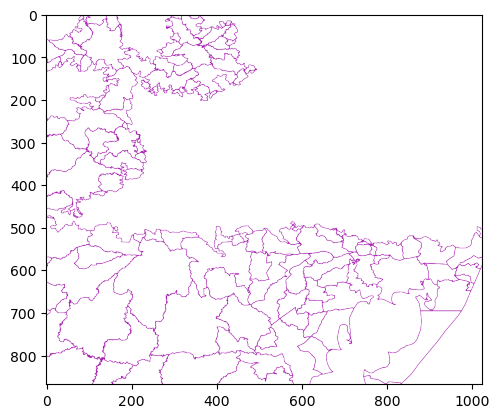

In [3]:
##https://terrabrasilis.dpi.inpe.br/app/map/alerts
# Conectar ao serviço WMS
wms_url = 'https://terrabrasilis.dpi.inpe.br/geoserver/prodes-pampa-nb/wms'
wms = WebMapService(wms_url)

camada_prodes = list(wms.contents)[5]

styles = list(wms[camada_prodes].styles)

epsg = wms[camada_prodes].boundingBox
epsg = epsg[4]  

# variavel bbox
bbox=wms[camada_prodes].boundingBoxWGS84

# Buscar a imagem do WMS para o município selecionado
img = wms.getmap(
    layers=[camada_municipios],
    styles=[styles[0]],
    srs=epsg,
    bbox=bbox,
    size=(1024, 868),  # Ajustar o tamanho da imagem conforme necessário
    format='image/png',
    transparent=True
)

# Ler os dados brutos da imagem
img_data = img.read()

# Verificar o tamanho dos dados da imagem
print(f"Length of image data: {len(img_data)}")

# Abrir a imagem usando PIL e converter para RGBA
image = Image.open(BytesIO(img_data)).convert('RGBA')

# Converter a imagem PIL para um array NumPy
image_array = np.array(image)

# Verificar as dimensões do array da imagem
print(f"Shape of the image array: {image_array.shape}")

# Exibir a imagem usando matplotlib
plt.imshow(image_array)
plt.show()

c) Focos de estudo

['accumulated_deforestation_2000', 'biome_border', 'cloud', 'conservation_units_pampa_biome', 'hydrography', 'indigenous_area_pampa_biome', 'municipalities_pampa_biome', 'states_pampa_biome', 'temporal_mosaic_pampa', 'yearly_deforestation']
accumulated_deforestation_2000
EPSG:4674
['accumulated_deforestation_2000_en']
Length of image data: 2083411
Shape of the image array: (2192, 3159, 4)


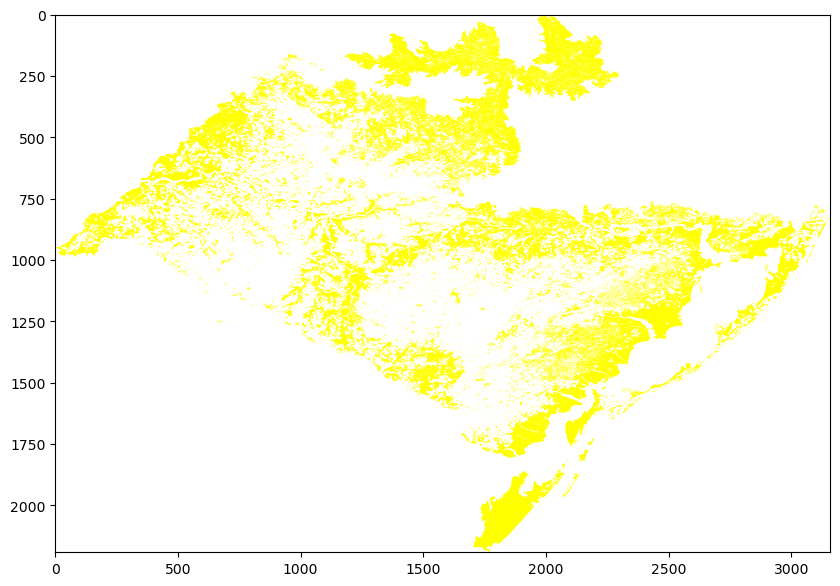

In [4]:
### WMS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
from owslib.wms import WebMapService

wms = WebMapService(url='https://terrabrasilis.dpi.inpe.br/geoserver/prodes-pampa-nb/wms') 
print(list(wms.contents))
camada = list(wms.contents)[0]
print(camada)
bbox=wms[camada].boundingBoxWGS84

epsg=wms[camada].boundingBox
epsg=epsg[4]
print(epsg)

styles = list(wms[camada].styles)
print(styles)

# [op.name for op in wms.operations]
# wms.getOperationByName('GetMap').formatOptions

img = wms.getmap(layers=[camada],
                styles=styles,
                srs=epsg,
                bbox=bbox,
                size=(3159, 2192),
                format='image/png',
                transparent=True
                )

fig, ax = plt.subplots(figsize=(10, 20))
# Read the raw image data
img_data = img.read()

# Check the length of the image data to ensure it matches the expected size
print(f"Length of image data: {len(img_data)}")

# Open the image using PIL and convert to RGBA
image = Image.open(BytesIO(img_data)).convert('RGBA')

# Convert the PIL image to a NumPy array
image_array = np.array(image)

# Print the shape of the image array to verify dimensions
print(f"Shape of the image array: {image_array.shape}") 

# Display the image using matplotlib
plt.imshow(image_array)
plt.show()


STAC

In [5]:
import folium
import rasterio
from pyproj import Transformer
from shapely import MultiPoint, Point
from pystac_client import Client



# Endereço do ponto de acesso ao serviço
datainpe = "https://data.inpe.br/bdc/stac/v1/"

# Cria um objeto para o catálogo
catalogo = Client.open(datainpe)

# Mostra algumas informações básicas do catálogo
print(f"ID: {catalogo.id}")
print(f"Título: {catalogo.title or 'N/A'}")
print(f"Descrição: {catalogo.description or 'N/A'}")

# Lista as coleções disponíveis no catálogo
collections = list(catalogo.get_collections())
print(f"Esse catálogo possui {len(collections)} coleções")
print("IDs coleções:")
for collection in collections:
    print(f"- {collection.id}")

# Consulta uma coleção em particular
name_sat = "S2_L2A-1"  #input("CB4A-WPM-PCA-FUSED-1 or S2_L2A-1")  #"S2_L2A-1"
# if name_sat != "CB4A-WPM-PCA-FUSED-1" or name_sat != "S2_L2A-1":
#     print('coleções diferentes')

satellite = catalogo.get_collection(name_sat)

print(f"ID: {satellite.id}")
print(f"Título: {satellite.title or 'N/A'}")
print(f"Descrição: {satellite.description or 'N/A'}")
print(f"Palavras chave: {satellite.keywords or 'N/A'}")

print(f"Ponto central do município: Latitude = {center_lat}, Longitude = {center_lon}")

# Define o raio do buffer ao redor do ponto central (em graus)
buffer_radius = 0.05  # Ajuste conforme necessário

# Cria um ponto e um buffer ao redor do ponto central
center_point = Point(center_lon, center_lat)
buffer_area = center_point.buffer(buffer_radius)

# Converte o buffer para uma caixa delimitadora
bbox = buffer_area.bounds
print(f"Bounding box ajustado com buffer ao redor do ponto central: {bbox}")

ID: INPE
Título: N/A
Descrição: This is the landing page for the INPE STAC server. The SpatioTemporal Asset Catalogs (STAC) provide a standardized way to expose collections of spatial temporal data. Here you will find collections of data provided by projects and areas of INPE.
Esse catálogo possui 36 coleções
IDs coleções:
- CBERS4-WFI-16D-2
- mosaic-cbers4a-paraiba-3m-1
- mosaic-s2-paraiba-3m-1
- mosaic-s2-yanomami_territory-6m-1
- CB4A-WPM-PCA-FUSED-1
- GOES16-L2-CMI-1
- LANDSAT-16D-1
- mod13q1-6.1
- myd13q1-6.0
- S2_L1C_BUNDLE-1
- mosaic-s2-cerrado-2m-1
- S2_L2A-1
- CBERS4-MUX-2M-1
- mod13q1-6.0
- S2-16D-2
- sentinel-1-grd-bundle-1
- S2_L2A_BUNDLE-1
- mosaic-landsat-amazon-3m-1
- CB4A-WFI-L4-SR-1
- sentinel-3-olci-l1-bundle-1
- mosaic-landsat-brazil-6m-1
- myd13q1-6.1
- CB4-WFI-L4-SR-1
- mosaic-s2-amazon-3m-1
- AMZ1-WFI-L4-SR-1
- charter-wfi-1
- CBERS-WFI-8D-1
- mosaic-s2-cerrado-4m-1
- CB4-MUX-L4-SR-1
- mosaic-cbers4-brazil-3m-1
- charter-mux-1
- mosaic-s2-amazon-1m-1
- GOES13-L3-I

d) Imagem Recentes do Sentinel-2

In [6]:
# Consulta com parâmetros
# Trocar a segunda data para ver as outras imagens usadas no artigo: 2024-02-04, 2024-01-15 e 2023-12-29
intervalo = "2023-12-01/2024-05-07"  # Período de consulta. 
search = catalogo.search(collections=[satellite.id], bbox=bbox, datetime=intervalo)  #com buffer pega uma data mais atual
items = search.item_collection()
print(f"A coleção {satellite.id} possui {len(items)} itens.")
# Apresenta os resultados
for i in items:
    print(f"ID: {i.id}")
    print(f"Data: {i.datetime or 'N/A'}")
    print(f"Geometria: {i.geometry or 'N/A'}")

# Verifica se não há itens e evita a execução do código subsequente
if len(items) == 0:
    print("Nenhum item encontrado.")
    # Utilize sys.exit() para encerrar o programa
    import sys
    sys.exit()

# Recupera os ativos da 1ª imagem
primeiro = items[0]
ativos = primeiro.assets
print(ativos.keys())

# print(ativos["thumbnail"].href)

if satellite.id == 'S2_L2A-1':
    print(ativos["TCI"].href)
    src_imgs = ativos["TCI"].href
    src_imgs = [str(src_imgs)]
else:
    print(ativos["tci"].href)
    src_imgs = ativos["tci"].href
    src_imgs = [str(src_imgs)]
    

print(src_imgs)

# Ponto de entrada ao serviço TMS do INPE
inpe_tms_endpoint = 'https://data.inpe.br/bdc/tms/tiles/WebMercatorQuad/{z}/{x}/{y}?url='

# Fórmula de realce opcional
color_enh = '&color_formula=gamma rg 1.3'

# Cria uma marca no centro de cada imagem
marks = []
for img in src_imgs:
    # Calcula o bounding box da imagem em EPSG
    with rasterio.open(img) as src:
        xmin, ymin, xmax, ymax = src.bounds
        transformer = Transformer.from_crs(src.crs, epsg, always_xy=True)
        center_lon, center_lat = transformer.transform(
            xmin + (xmax - xmin) / 2.0,
            ymin + (ymax - ymin) / 2.0
        )
        marks.append(Point(center_lat, center_lon))

# Cria um mapa centralizado no centroide de todas as marcas
zoom = 10  # Ajuste o nível de zoom conforme necessário
points = MultiPoint(marks)
center = points.centroid
map_center = [center.x, center.y]  # Note que center.x é latitude e center.y é longitude
map = folium.Map(location=map_center, zoom_start=zoom)

# Adiciona as imagens ao mapa
for i, img in enumerate(src_imgs):
    # Cria um layer TMS para cada imagem
    folium.TileLayer(
        tiles=inpe_tms_endpoint + img + color_enh,
        opacity=1,
        attr="INPE"
    ).add_to(map)

    # Cria uma marca com o identificador para cada imagem
    img_id = img[img.rfind('/') + 1:]
    folium.Marker(
        location=[marks[i].x, marks[i].y],
        popup=img_id
    ).add_to(map)

# Mostra o mapa
map

# # Ou salva para um arquivo HTML
# map.save("index.html")

A coleção S2_L2A-1 possui 65 itens.
ID: S2B_MSIL2A_20240506T133149_N0510_R081_T22JDM_20240506T154438
Data: 2024-05-06 13:31:49+00:00
Geometria: {'type': 'Polygon', 'coordinates': [[[-51.01383127585912, -29.83002249563997], [-51.03203797620911, -29.90216623037917], [-51.05857340031493, -30.0066892344005], [-51.06992058087492, -30.051272665653887], [-51.10739222693205, -30.19900414131485], [-51.14493480590839, -30.34670659409293], [-51.14784998259397, -30.358147307114724], [-51.18231847347641, -30.492899662429547], [-51.22010441311316, -30.640508842600784], [-51.25799954604155, -30.788075024515383], [-51.26621931856864, -30.819938741821687], [-52.04589292919201, -30.817099016489806], [-52.03542020095416, -29.8264095228299], [-51.01383127585912, -29.83002249563997]]]}
ID: S2B_MSIL2A_20240503T132229_N0510_R038_T22JDM_20240503T153146
Data: 2024-05-03 13:22:29+00:00
Geometria: {'type': 'Polygon', 'coordinates': [[[-51.939404334149515, -30.81748686899216], [-51.91430748701761, -30.73180848465

In [7]:
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal

path = str(ativos["TCI"].href)
img = rasterio.open(path).read()
img_crop = img[:,10:3210,5000:9000] 

print(img_crop.shape)

(3, 3200, 4000)


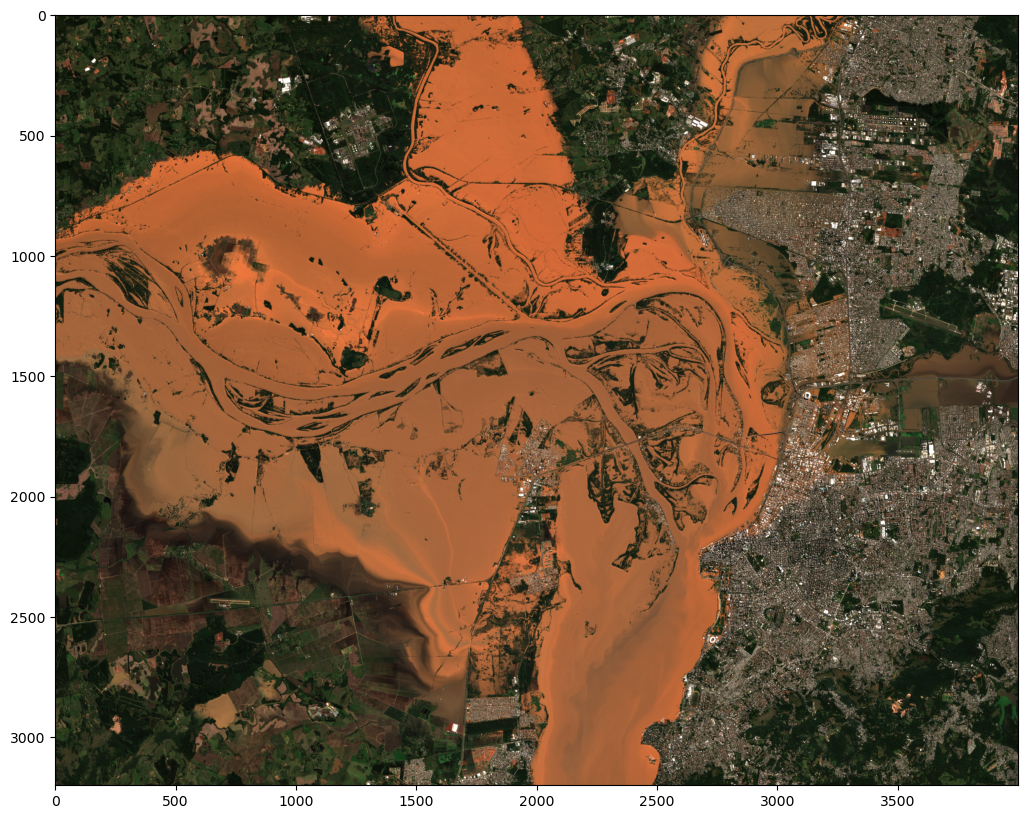

In [8]:
img_c = np.stack([img_crop[0],img_crop[1],
                  img_crop[2]], axis=2)

img = img_c / img_c.max()
plt.figure(figsize=(15, 10))
plt.imshow(img)